In [1]:
####################################
#ENVIRONMENT SETUP

In [2]:
#Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import ScalarFormatter
import matplotlib.gridspec as gridspec
import xarray as xr

import sys; import os; import time; from datetime import timedelta
import pickle
import h5py

In [3]:
#MAIN DIRECTORIES
def GetDirectories():
    mainDirectory='/mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/'
    mainCodeDirectory=os.path.join(mainDirectory,"Code/CodeFiles/")
    scratchDirectory='/mnt/lustre/koa/scratch/air673/'
    codeDirectory=os.getcwd()
    return mainDirectory,mainCodeDirectory,scratchDirectory,codeDirectory

[mainDirectory,mainCodeDirectory,scratchDirectory,codeDirectory] = GetDirectories()

In [4]:
def GetPlottingDirectory(plotFileName, plotType):
    plottingDirectory = mainCodeDirectory=os.path.join(mainDirectory,"Code","PLOTTING")
    
    specificPlottingDirectory = os.path.join(plottingDirectory, plotType, 
                                             f"{ModelData.res}_{ModelData.t_res}_{ModelData.Nz_str}nz")
    os.makedirs(specificPlottingDirectory, exist_ok=True)

    plottingFileName=os.path.join(specificPlottingDirectory, plotFileName)

    return plottingFileName

def SaveFigure(fig,plotType, fileName):
    plotFileName = f"{fileName}_{ModelData.res}_{ModelData.t_res}_{ModelData.Np_str}.jpg"
    plottingFileName = GetPlottingDirectory(plotFileName, plotType)
    print(f"Saving figure to {plottingFileName}")
    fig.savefig(plottingFileName, dpi=300, bbox_inches='tight')

In [5]:
#IMPORT CLASSES
sys.path.append(os.path.join(mainCodeDirectory,"2_Variable_Calculation"))
from CLASSES_Variable_Calculation import ModelData_Class, SlurmJobArray_Class, DataManager_Class

In [6]:
#IMPORT CLASSES
sys.path.append(os.path.join(mainCodeDirectory,"3_Project_Algorithms","1_Domain_Profiles"))
from CLASSES_DomainProfiles import DomainProfiles_Class, DomainProfiles_DataLoading_Class

In [7]:
import sys
path=os.path.join(mainCodeDirectory,'Functions/')
sys.path.append(path)

import NumericalFunctions
from NumericalFunctions import * # import NumericalFunctions 
import PlottingFunctions
from PlottingFunctions import * # import PlottingFunctions

# # Get all functions in NumericalFunctions
# import inspect
# functions = [f[0] for f in inspect.getmembers(NumericalFunctions, inspect.isfunction)]
# functions

#####

#Import StatisticalFunctions 
import sys
dir2='/mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/'
path=dir2+'Functions/'
sys.path.append(path)

import StatisticalFunctions
from StatisticalFunctions import * # import NumericalFunctions 

In [8]:
dataName="Entrainment"

#data loading class
ModelData = ModelData_Class(mainDirectory, scratchDirectory, simulationNumber=1)
#data manager class
DataManager = DataManager_Class(mainDirectory, scratchDirectory, ModelData.res, ModelData.t_res, ModelData.Nz_str,
                                ModelData.Np_str, dataType="Domain_Profiles", dataName=dataName,
                                dtype='float32',codeSection = "Project_Algorithms")

=== CM1 Data Summary ===
 Simulation #:   1
 Resolution:     1km
 Time step:      5min
 Vertical levels:34
 Parcels:        1e6
 Data file:      /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Model/cm1r20.3/run/cm1out_1km_5min_34nz.nc
 Parcel file:    /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Model/cm1r20.3/run/cm1out_pdata_1km_5min_1e6np.nc
 Time steps:     133

=== DataManager Summary ===
 inputDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/TimeSplitModelData
 outputDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Project_Algorithms/Domain_Profiles
 inputDataDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/TimeSplitModelData/1km_5min_34nz/ModelData
 inputParcelDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-P

In [9]:
####################################
#PLOTTING FUNCTIONS

In [10]:
def LoadMeanLFC():
    # dir2 = dir + f'Project_Algorithms/Tracking_Algorithms/OUTPUT/'
    # in_file = dir2 + f"MeanLFC_{res}_{t_res}_{Np_str}.pkl"
    # with open(in_file, 'rb') as f:
    #     MeanLFC = pickle.load(f)
    MeanLFC=2 #*#*
    return MeanLFC
MeanLFC=LoadMeanLFC()
print(f"Mean LFC is: {MeanLFC}\n")


def LoadAllCloudBase():
    # dir2 = dir + f'Project_Algorithms/Tracking_Algorithms/OUTPUT/'
    # in_file = dir2 + f"all_cloudbase_{res}_{t_res}_{Np_str}.pkl"
    # with open(in_file, 'rb') as f:
    #     all_cloudbase = pickle.load(f)
    all_cloudbase=1 #*#*
    return(all_cloudbase)
min_all_cloudbase=np.nanmin(LoadAllCloudBase())
cloudbase=min_all_cloudbase
print(f"Minimum Cloudbase is: {cloudbase}\n")

Mean LFC is: 2

Minimum Cloudbase is: 1



In [11]:
#thresholds
w_thresh1,w_thresh2,qcqi_thresh = DomainProfiles_DataLoading_Class.GetCloudyUpdraftThresholds()

In [93]:
def ApplyEntrainmentConstant(profile):
    entrainmentDirectory = os.path.normpath(os.path.join(DataManager.inputDataDirectory,"../../../","EntrainmentCalculation",f"{ModelData.res}_{ModelData.t_res}_{ModelData.Nz_str}nz","EntrainmentCalculation"))
        
    entrainmentConstant = DataManager.LoadCalculations(entrainmentDirectory,
                                                       dataName="EntrainmentConstant",
                                                       verbose=False)["entrainmentConstant"]
    
    profile[:,0] *=  entrainmentConstant

    return profile
    
def ApplyEntrainmentConstantProfiles(Dictionary, varNames, datatype):
    """
    Apply entrainment constant to both mean and standard error profiles.
    """
    for varName in varNames:
        key1 = f"{varName}_{datatype}_timeaverage"
        key2 = f"{varName}_squares_{datatype}_timeaverage"
        for key in [key1,key2]:
            Dictionary[key] = ApplyEntrainmentConstant(Dictionary[key])

    return Dictionary

def LoadProfiles(datatype, masked, varNames):
    Dictionary = DomainProfiles_DataLoading_Class.LoadProfile(ModelData,DataManager, dataName, datatype,"timeaverage",masked)

    # apply entrainment constant
    Dictionary = ApplyEntrainmentConstantProfiles(Dictionary, varNames, datatype)
    
    Dictionary_SE = {}
    for varName in varNames:
        one=Dictionary[f"{varName}_{datatype}_timeaverage"]
        two=Dictionary[f"{varName}_squares_{datatype}_timeaverage"]
        Dictionary_SE[f"{varName}_{datatype}_timeaverage_SE"] = ProfileStandardError(one,two)
    
    factor=1.96
    return Dictionary, Dictionary_SE, factor

In [163]:
varName = "Entrainment"
masked = True
varNames = ['Entrainment_g','Entrainment_c',
            'TransferEntrainment_g',
            'TransferEntrainment_c']
varNames += ['Detrainment_g','Detrainment_c',
             'TransferDetrainment_g',
             'TransferDetrainment_c']

datatype='general'
[Dictionary_general, Dictionary_general_SE, factor] = LoadProfiles(datatype, masked, varNames)
datatype='cloudy'
[Dictionary_cloudy, Dictionary_cloudy_SE, factor] = LoadProfiles(datatype, masked, varNames)

In [161]:
import matplotlib.pyplot as plt

def plot_entrainment_profiles(ax, Dictionary_general, Dictionary_cloudy, factor=1, lw=1):
    var_names = ['e', 'd', 'net']
    colors = {'e': 'blue', 'd': 'red', 'net': 'k'}
    styles = {'g': '--', 'c': '-'}

    # e_g = Dictionary_general["Entrainment_g_general_timeaverage"] 
    # d_g = Dictionary_general["Detrainment_g_general_timeaverage"]

    #placeholders
    e_g = Dictionary_cloudy["Entrainment_c_cloudy_timeaverage"]
    d_g = Dictionary_cloudy["Detrainment_c_cloudy_timeaverage"]
    
    e_c = Dictionary_cloudy["Entrainment_c_cloudy_timeaverage"]
    d_c = Dictionary_cloudy["Detrainment_c_cloudy_timeaverage"]

    # --- Process Both Types ---
    out_e_g = ProfileMean(e_g)
    out_d_g = ProfileMean(d_g); out_d_g[:,0]*=1
    out_net_g = out_e_g.copy()
    out_net_g[:,0] = out_e_g[:,0] - out_d_g[:,0]

    out_e_c = ProfileMean(e_c)
    out_d_c = ProfileMean(d_c); out_d_c[:,0]*=-1
    out_net_c = out_e_g.copy()
    out_net_c[:,0] = out_e_c[:,0] - out_d_c[:,0]
    
    for suffix in ['c', 'g']:
        for var in var_names:
            varname = f'out_{var}_{suffix}'
            profile = locals()[varname]
            # profile_SE_name = f'{var}_{suffix}_SE'
            # profile_SE = globals().get(profile_SE_name, None) 
            profile_SE = None

            label_suffix = 'general' if suffix == 'g' else 'cloudy'
            ax.plot(
                profile[:, 0],
                profile[:, 1],
                color=colors[var],
                linestyle=styles[suffix],
                linewidth=lw,
                label=f'{var} ({label_suffix})'
            )

            # Uncomment below if you want to plot error shading and SE data exists
            if profile_SE is not None:
                hatch = '///' if suffix == 'g' else ""
                ax.fill_betweenx(
                    profile[:, 1],
                    profile[:, 0] - factor * profile_SE[:, 0],
                    profile[:, 0] + factor * profile_SE[:, 0],
                    color=colors[var],
                    alpha=0.1,
                    hatch=hatch
                )

    ax.grid(True)
    ax.axvline(0, color='k', linewidth=lw)
    ax.set_xlabel(r"($kg m^{-3} s^{-1}$)") 
    ax.set_ylabel('z (km)')

    # Apply scientific notation helper if you have one
    apply_scientific_notation([ax])

    # Cloud base and mean LFC lines
    ax.axhline(cloudbase, color='purple', linestyle='dashed', lw=1.2)
    ax.axhline(MeanLFC, color='green', linestyle='dashed', lw=1.2)

    # ax.set_title('Entrainment: General (dashed) vs Cloudy (solid)')
    ax.set_ylim(bottom=0)
    ax.legend()

In [178]:
#RATIO PLOT

def nandivide(numerator_array, denominator_array):
    """
    Performs element-wise division returning NaN where denominator == 0.
    Silently ignores divide-by-zero and invalid operation warnings.
    """
    numerator_array = np.asarray(numerator_array, dtype=float)
    denominator_array = np.asarray(denominator_array, dtype=float)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        result = np.where(denominator_array == 0, np.nan, numerator_array / denominator_array)
    
    return result

def plot_entrainment_transition_profiles_combined(ax, c_to_g_E, g_to_c_E, c_to_g_D, g_to_c_D):
    mean_c_to_g_E = ProfileMean(c_to_g_E)
    mean_g_to_c_E = ProfileMean(g_to_c_E)
    mean_c_to_g_D = ProfileMean(c_to_g_D)
    mean_g_to_c_D = ProfileMean(g_to_c_D)

    ax.plot(mean_g_to_c_E[:, 0], mean_g_to_c_E[:, 1], color='blue', label=f'General → Cloudy (Entrainment)',linestyle='solid')
    ax.plot(mean_c_to_g_E[:, 0], mean_c_to_g_E[:, 1], color='red', label=f'Cloudy → General (Entrainment)',linestyle='solid')
    ax.plot(mean_c_to_g_D[:, 0], mean_c_to_g_D[:, 1], color='blue', label=f'Cloudy → General (Detrainment)',linestyle='dashed')
    ax.plot(mean_g_to_c_D[:, 0], mean_g_to_c_D[:, 1], color='red', label=f'General → Cloudy (Detrainment)',linestyle='dashed')
    
    ax.axvline(0, color='k')
    ax.set_xlabel(r"($kg m^{-3} s^{-1}$)") 
    ax.set_ylabel('z (km)')

    apply_scientific_notation([ax])  # if you have this function defined

    ax.grid(True)
    ax.axhline(cloudbase, color='purple', linestyle='dashed', lw=1.2)
    ax.axhline(MeanLFC, color='green', linestyle='dashed', lw=1.2)

    # ax.set_title('Entrainment Transition: c_to_g (general) & g_to_c (cloudy)')
    ax.set_ylim(bottom=0)
    ax.legend()

def plot_transfer_ratio(ax, c_to_g_E,g_to_c_E,c_to_g_D,g_to_c_D, e_g,d_g,e_c,d_c, title, lw=1):
    # Apply averaging
    mean_c_to_g_E = ProfileMean(c_to_g_E)  # shape: (N, 2)
    mean_g_to_c_E = ProfileMean(g_to_c_E)
    mean_c_to_g_D = ProfileMean(c_to_g_D)  # shape: (N, 2)
    mean_g_to_c_D = ProfileMean(g_to_c_D)
    
    mean_e_g = ProfileMean(e_g)
    mean_d_g = ProfileMean(d_g)
    mean_e_c = ProfileMean(e_c)
    mean_d_c = ProfileMean(d_c)

    # Align everything to a common vertical coordinate (z), using mean_d_c
    z_ref = mean_d_c[:, 1]

    def align(profile, z_target):
        idx = np.where(profile[:, 1] == z_target[0])[0]
        return profile[idx[0]:] if idx.size > 0 else profile

    mean_c_to_g_E = align(mean_c_to_g_E, z_ref)
    mean_g_to_c_E = align(mean_g_to_c_E, z_ref)
    mean_c_to_g_D = align(mean_c_to_g_D, z_ref)
    mean_g_to_c_D = align(mean_g_to_c_D, z_ref)
    
    mean_e_g = align(mean_e_g, z_ref)
    mean_d_g = align(mean_d_g, z_ref)
    mean_e_c = align(mean_e_c, z_ref)
    # mean_d_c already aligned

    z = z_ref  # in km

    # Compute ratios
    ratio_1 = nandivide(mean_g_to_c_E[:, 0], mean_e_c[:, 0])  # Blue
    ratio_2 = nandivide(mean_g_to_c_D[:, 0], mean_d_g[:, 0])  # Red
    ratio_3 = nandivide(mean_c_to_g_E[:, 0], mean_e_g[:, 0])  # Light Blue
    ratio_4 = nandivide(mean_c_to_g_D[:, 0], mean_d_c[:, 0])  # Orange

    # Plot ratios
    ax.plot(ratio_1*100, z, color='blue', label='General → Cloudy / Cloudy Entrainment')
    ax.plot(ratio_2*100, z, color='deepskyblue', label='General → Cloudy / General Detrainment')
    ax.plot(ratio_3*100, z, color='red', label='Cloudy → General / General Entrainment')
    ax.plot(ratio_4*100, z, color='orangered', label='Cloudy → General / Cloudy Detrainment')

    ax.grid(True)
    ax.set_title(title)
    ax.set_xlabel('%')
    # ax.set_xlabel('Ratio')
    ax.set_ylabel('z (km)')
    # ax.set_xlim(-0.05, 1.05)  # Add 10% padding
    ax.set_xlim(-5, 105)  # Add 10% padding
    ax.set_ylim(bottom=0)
    ax.legend(loc='center right', fontsize=10.5-1)

    ax.axvline(0, color='k', linewidth=lw)
    # ax.axvline(1, color='black', linestyle='dashed', linewidth=1)
    ax.axvline(100, color='black', linestyle='dashed', linewidth=1)
    ax.axhline(cloudbase, color='purple', linestyle='dashed', lw=1.2)
    ax.axhline(MeanLFC, color='green', linestyle='dashed', lw=1.2)
    apply_scientific_notation([ax],decimals=2,scientific=True)

In [179]:
Dictionary.keys()

dict_keys(['Detrainment_c_cloudy_timeaverage', 'Detrainment_c_squares_cloudy_timeaverage', 'Detrainment_g_cloudy_timeaverage', 'Detrainment_g_squares_cloudy_timeaverage', 'Entrainment_c_cloudy_timeaverage', 'Entrainment_c_squares_cloudy_timeaverage', 'Entrainment_g_cloudy_timeaverage', 'Entrainment_g_squares_cloudy_timeaverage', 'TransferDetrainment_c_cloudy_timeaverage', 'TransferDetrainment_c_squares_cloudy_timeaverage', 'TransferDetrainment_g_cloudy_timeaverage', 'TransferDetrainment_g_squares_cloudy_timeaverage', 'TransferEntrainment_c_cloudy_timeaverage', 'TransferEntrainment_c_squares_cloudy_timeaverage', 'TransferEntrainment_g_cloudy_timeaverage', 'TransferEntrainment_g_squares_cloudy_timeaverage'])

In [180]:
def load_entrainment_transition_profiles(Dictionary_general, Dictionary_cloudy):


    #general updrafts
    c_to_g_E_general = Dictionary_general['TransferEntrainment_g_general_timeaverage']
    c_to_g_D_general = Dictionary_general['TransferDetrainment_c_general_timeaverage']
    g_to_c_E_general = Dictionary_general['TransferEntrainment_c_general_timeaverage']
    g_to_c_D_general = Dictionary_general['TransferDetrainment_g_general_timeaverage']

    #cloudy updrafts
    c_to_g_E_cloudy = Dictionary_cloudy['TransferEntrainment_g_cloudy_timeaverage']
    c_to_g_D_cloudy = Dictionary_cloudy['TransferDetrainment_c_cloudy_timeaverage']
    g_to_c_E_cloudy = Dictionary_cloudy['TransferEntrainment_c_cloudy_timeaverage'] 
    g_to_c_D_cloudy = Dictionary_cloudy['TransferDetrainment_g_cloudy_timeaverage']

    return {
        'c_to_g_E_general': c_to_g_E_general,
        'c_to_g_D_general': c_to_g_D_general, #zero
        'g_to_c_E_general': g_to_c_E_general, #zero
        'g_to_c_D_general': g_to_c_D_general, #zero
        'c_to_g_E_cloudy': c_to_g_E_cloudy, #zero
        'c_to_g_D_cloudy': c_to_g_D_cloudy, #zero
        'g_to_c_E_cloudy': g_to_c_E_cloudy,
        'g_to_c_D_cloudy': g_to_c_D_cloudy,
    }

load_profiles = load_entrainment_transition_profiles(Dictionary_general, Dictionary_cloudy)

c_to_g_E_general = load_profiles['c_to_g_E_general']
c_to_g_D_general = load_profiles['c_to_g_D_general']
g_to_c_E_general = load_profiles['g_to_c_E_general']
g_to_c_D_general = load_profiles['g_to_c_D_general']
c_to_g_E_cloudy  = load_profiles['c_to_g_E_cloudy']
c_to_g_D_cloudy  = load_profiles['c_to_g_D_cloudy']
g_to_c_E_cloudy  = load_profiles['g_to_c_E_cloudy']
g_to_c_D_cloudy  = load_profiles['g_to_c_D_cloudy']

Saving figure to /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/PLOTTING/Project_Algorithms/Domain_Profiles/Eulerian_Profiles_Entrainment/1km_5min_34nz/Eulerian_Profiles_Entrainment_1km_5min_1e6.jpg


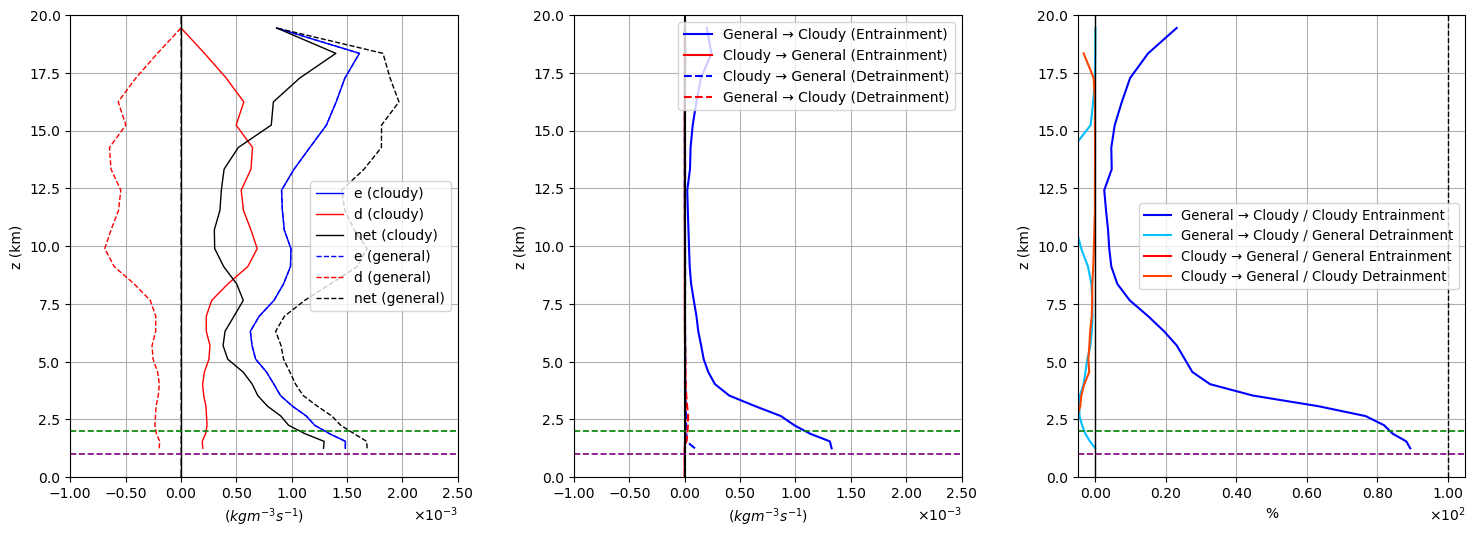

In [183]:
fig = plt.figure(figsize=(18, 6))
gs = gridspec.GridSpec(1, 3, figure=fig, wspace=0.3)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

plot_entrainment_profiles(ax1, Dictionary_general, Dictionary_cloudy)
plot_entrainment_transition_profiles_combined(ax2, c_to_g_E_general,g_to_c_E_cloudy, c_to_g_D_cloudy,g_to_c_D_general)
plot_transfer_ratio(ax3, c_to_g_E_general,g_to_c_E_cloudy,c_to_g_D_cloudy,g_to_c_D_general, e_g,d_g,e_c,d_c, title="") 

axes=[ax1,ax2]
#FIXING TICKS
MatchAxisLimits(axes,dim='x')

for axis in [ax1,ax2,ax3]:
    axis.set_ylim(0,20)

#ADDING AXVLINES
for ax in axes:
    ax.axvline(0,color='gray',linestyle='dashed',zorder=-10)

fileName=f"Eulerian_Profiles_Entrainment" 
SaveFigure(fig,plotType="Project_Algorithms/Domain_Profiles/Eulerian_Profiles_Entrainment",fileName=fileName)